In [1]:
n_fold= 1
total_fold= '5'
use_enchanced_dataset= False
model_name= "MX2-Net"

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import time
from tqdm.notebook import tqdm

# Keras
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from keras import *
from keras.models import Model, Sequential, model_from_json, load_model
from tensorflow.keras.preprocessing import image_dataset_from_directory
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import *
from keras.callbacks import ModelCheckpoint,EarlyStopping,TensorBoard,CSVLogger,ReduceLROnPlateau
from keras import backend as K
#from keras.applications.densenet import DenseNet121

import util
from sklearn.metrics import confusion_matrix, classification_report
from livelossplot import PlotLossesKeras
from keras.initializers import RandomNormal
from swintransformer import SwinTransformer

/home/cries/.conda/envs/jeremie_env/lib/python3.9/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.3.0 and strictly below 2.6.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.11.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
if gpus:
    tf.config.set_visible_devices(gpus[2], 'GPU')

print("Test built: {}".format(tf.test.is_built_with_cuda()))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU')]
Test built: True


In [4]:
if use_enchanced_dataset == True:
    IMAGE_DIR = "/home/cries/Dataset/X-Ray/enchanced/"
else:
    IMAGE_DIR = "/home/cries/Dataset/X-Ray/original/images/"
    
train_df= pd.read_csv("/home/cries/Dataset/X-Ray/DataFrame/" + str(total_fold) + "Fold/" + "train_Fold" + str(n_fold) + ".csv").loc[:,'Image Index':]
test_df= pd.read_csv("/home/cries/Dataset/X-Ray/DataFrame/" + str(total_fold) + "Fold/" + "test_Fold" + str(n_fold) + ".csv").loc[:,'Image Index':]

labels = ['No Findings',
          'Cardiomegaly', 
          'Emphysema', 
          'Effusion', 
          'Hernia', 
          'Infiltration', 
          'Mass', 
          'Nodule', 
          'Atelectasis',
          'Pneumothorax',
          'Pleural_Thickening', 
          'Pneumonia', 
          'Fibrosis', 
          'Edema', 
          'Consolidation']

print("Leakage between train and test: {}".format(util.check_for_leakage(train_df, test_df, 'Image Index')))

Leakage between train and test: False


In [5]:
# Setting
seed= 1
batch_size= 32
# target_w= 320; target_h= 320; dim= (3,)
target_w= 224; target_h= 224; dim= (3,)
image_size_target= (target_w,target_h)
image_shape= image_size_target + dim
class_mode= 'raw'   # raw, categorical 

use_aug= False
use_normalize= True
index_col= "Image Index"
labels_col= labels

def prepare_generator(use_Aug, use_Normalize):
    # == Aug Image
    if use_Aug== True and use_Normalize== False:
        return ImageDataGenerator(
            rescale= 1./255,        
            horizontal_flip= True,
            height_shift_range= 0.5,
            width_shift_range= 0.5,
            vertical_flip= True,
            rotation_range= 20,
            fill_mode= "nearest"
            )
    # == Normalize Image
    if use_Aug== False and use_Normalize== True:
        return ImageDataGenerator(
            samplewise_center= True,
            samplewise_std_normalization= True
            )
    # == Without
    if use_Aug== False and use_Normalize== False:
        return ImageDataGenerator()

============ getting train generator ===========
Found 4484 validated image filenames.

==== getting train and test/valid generators ====
Found 4484 validated image filenames.
Found 1122 validated image filenames.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


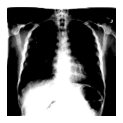

In [6]:
# === Image Train Generator
print("============ getting train generator ===========") 
image_train= prepare_generator(use_Aug=False, use_Normalize=True).flow_from_dataframe(
    dataframe= train_df,
    directory= IMAGE_DIR,
    x_col= index_col,
    y_col= labels,
    class_mode= class_mode,
    batch_size= batch_size,
    shuffle= True,
    target_size= image_size_target
)

# === Image Validation and Test Generator
print("")
print("==== getting train and test/valid generators ====")
raw_train_generator= prepare_generator(False, False).flow_from_dataframe(
                        dataframe= train_df,
                        directory= IMAGE_DIR,
                        x_col= index_col,
                        y_col= labels,
                        class_mode= class_mode,
                        batch_size= batch_size,
                        shuffle= True,
                        target_size= image_size_target
                    )
batch= raw_train_generator.next()
data_sample= batch[0]
imagegenerator= prepare_generator(False, True)
imagegenerator.fit(data_sample)
image_val = imagegenerator.flow_from_dataframe(
                        dataframe= test_df,
                        directory= IMAGE_DIR,
                        x_col= index_col,
                        y_col= labels,
                        class_mode= class_mode,
                        batch_size= batch_size,
                        shuffle= False,
                        target_size= image_size_target
                    )

x, y = image_train.__getitem__(0)
plt.figure(figsize=(2,2))
plt.axis('off')
plt.imshow(x[0]);

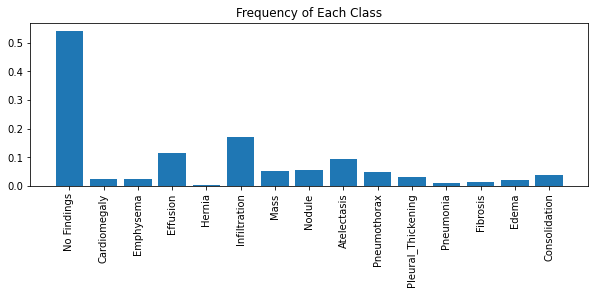

In [7]:
plt.figure(figsize=(10,3))
plt.xticks(rotation=90)
plt.bar(x=labels, height=np.mean(image_train.labels, axis=0))
plt.title("Frequency of Each Class")
plt.show()

In [8]:
def compute_class_freqs(labels):
    # total number of patients (rows)
    N = labels.shape[0]
    positive_frequencies = np.sum(labels, axis = 0) / N
    negative_frequencies = 1 - positive_frequencies
    return positive_frequencies, negative_frequencies

freq_pos, freq_neg = compute_class_freqs(image_train.labels)
freq_pos

array([0.54192685, 0.02520071, 0.02363961, 0.11641392, 0.00223015,
       0.17105263, 0.05307761, 0.0544157 , 0.0941124 , 0.04772525,
       0.03077609, 0.01137377, 0.01449599, 0.02118644, 0.0396967 ])

<ipython-input-9-5b7fdcf061fc>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append([{"Class": labels[l], "Label": "Negative", "Value": v} for l,v in enumerate(freq_neg)], ignore_index=True)


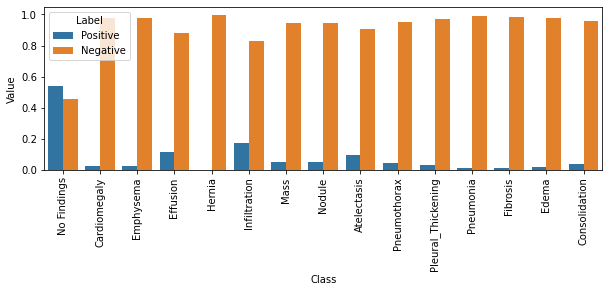

In [9]:
data = pd.DataFrame({"Class": labels, "Label": "Positive", "Value": freq_pos})
data = data.append([{"Class": labels[l], "Label": "Negative", "Value": v} for l,v in enumerate(freq_neg)], ignore_index=True)
plt.figure(figsize=(10,3))
plt.xticks(rotation=90)
f = sns.barplot(x="Class", y="Value", hue="Label" ,data=data)

<ipython-input-10-705df616134b>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append([{"Class": labels[l], "Label": "Negative", "Value": v}


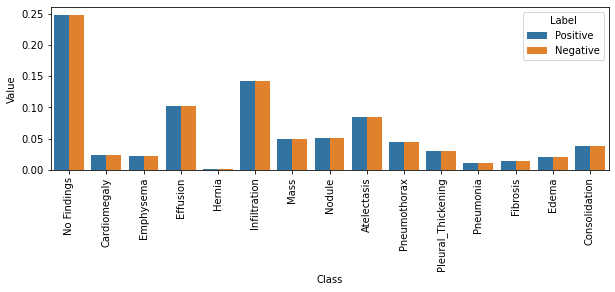

In [10]:
pos_weights = freq_neg
neg_weights = freq_pos
pos_contribution = freq_pos * pos_weights 
neg_contribution = freq_neg * neg_weights

data = pd.DataFrame({"Class": labels, "Label": "Positive", "Value": pos_contribution})
data = data.append([{"Class": labels[l], "Label": "Negative", "Value": v} 
                        for l,v in enumerate(neg_contribution)], ignore_index=True)
plt.figure(figsize=(10,3))
plt.xticks(rotation=90)
sns.barplot(x="Class", y="Value", hue="Label" ,data=data);

In [11]:
image_shape

(224, 224, 3)

In [12]:
num_class = len(labels)

In [13]:
inputs= Input(shape=(224,224,3))

In [14]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

def VAE(encoder_inputs):
    latent_dim = 2
    x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
    x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
    x = layers.Flatten()(x)
    x = layers.Dense(16, activation="relu")(x)
    z_mean = layers.Dense(latent_dim, name="z_mean")(x)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
    latent_inputs = Sampling()([z_mean, z_log_var])

    x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
    x = layers.Reshape((7, 7, 64))(x)
    x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
    x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
    decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
    
    outputs = LayerNormalization()(decoder_outputs)
    return Model(inputs=encoder_inputs, outputs=outputs)

In [15]:
######################### MODEL AE ###################################
ae_Model = VAE(inputs)

######################### MODEL 1 ###################################
swin = SwinTransformer('swin_large_224', include_top=False, pretrained=True)(inputs)
swin = LayerNormalization()(swin)
swin_output = Flatten()(swin)

f1_Model = Model(inputs, swin_output)
f1_Model.trainable = False

######################### MODEL 2 ###################################
f2 = Conv2D(32, kernel_size=2, padding="same", activation = "relu")(ae_Model.output)
f2 = Conv2D(32, kernel_size=2, padding="valid", activation = "relu")(f2)
f2 = -MaxPooling2D(pool_size=2, padding="valid", name="MinPooling2D_I")(-f2)
f2 = LayerNormalization()(f2)

f2 = Conv2D(16, kernel_size=3, padding="same", activation = "relu")(f2)
f2 = Conv2D(16, kernel_size=3, padding="valid", activation = "relu")(f2)
f2 = -MaxPooling2D(pool_size=2, padding="valid", name="MinPooling2D_II")(-f2)
f2 = LayerNormalization()(f2)
f2 = Conv2D(8, kernel_size=3, padding="same", activation = "relu")(f2)
f2 = Conv2D(8, kernel_size=3, padding="valid", activation = "relu")(f2)
f2 = LayerNormalization()(f2)

f2 = Flatten()(f2)
f2_Model = Model(inputs=inputs, outputs=f2)

######################### Classifier ###################################
merged_neck = keras.layers.concatenate([(f1_Model.output), (f2_Model.output)])
neck = LayerNormalization()(merged_neck)

x1 = layers.Dense(3060*3, activation='swish')(neck)
x1 = layers.Dense(2048*3, activation='swish')(x1)
x1 = LayerNormalization()(x1)
x1 = layers.Dense(256*3, activation='swish')(x1)
x1 = layers.Dense(64*3, activation='swish')(x1)
x1 = LayerNormalization()(x1)
x1 = Flatten()(x1)

x2 = layers.Dense(2048*3, activation='swish')(Flatten()(ae_Model.output))
x2 = layers.Dense(1024*3, activation='swish')(x2)
x2 = LayerNormalization()(x2)
x2 = layers.Dense(128*3, activation='swish')(x2)
x2 = layers.Dense(32*3, activation='swish')(x2)
x2 = LayerNormalization()(x2)
x2 = Flatten()(x2)

z = keras.layers.concatenate([x1, x2])
ln2 = LayerNormalization()(z)

z1 = layers.Dense(4096*3, activation='swish')(ln2)
z1 = LayerNormalization()(z1)
z1 = layers.Dense(3250*3, activation='swish')(z1)
z1 = LayerNormalization()(z1)
z1 = layers.Dense(2048*3, activation='swish')(z1)
z1 = layers.Dense(1024*3, activation='swish')(z1)
z1 = LayerNormalization()(z1)
z1 = layers.Dense(256*3, activation='swish')(z1)
z1 = layers.Dense(64*3, activation='swish')(z1)
z1 = LayerNormalization()(z1)
z1 = layers.Dense(16*3, activation='swish')(z1)

predictions = layers.Dense(num_class, activation='softmax')(z1)

In [16]:
model = Model(inputs, predictions)

In [17]:
epoch = 25

lr = 0.001
decay_rate = lr / epoch
momentum = 0.99
adam = tf.keras.optimizers.Adam(learning_rate=lr, beta_1=decay_rate, beta_2=decay_rate*decay_rate, epsilon=1e-07, amsgrad=False)
sgd = tf.keras.optimizers.SGD(learning_rate=lr, momentum=momentum, weight_decay=decay_rate, nesterov=False)
checkpoint = ModelCheckpoint("ckp_{}.hdf5".format(model_name), monitor='loss', verbose=1, save_best_only=True, mode='auto', period=1)

# class_weigths = dict(zip(range(len(neg_weights)), neg_weights))
# weighted_loss = get_weighted_loss(pos_weights, neg_weights)
bfce_ls = tf.losses.BinaryCrossentropy(label_smoothing = 0.0)

metric_auc = tf.keras.metrics.AUC(multi_label=True)

model.compile(loss=bfce_ls, optimizer=adam, metrics=[metric_auc])

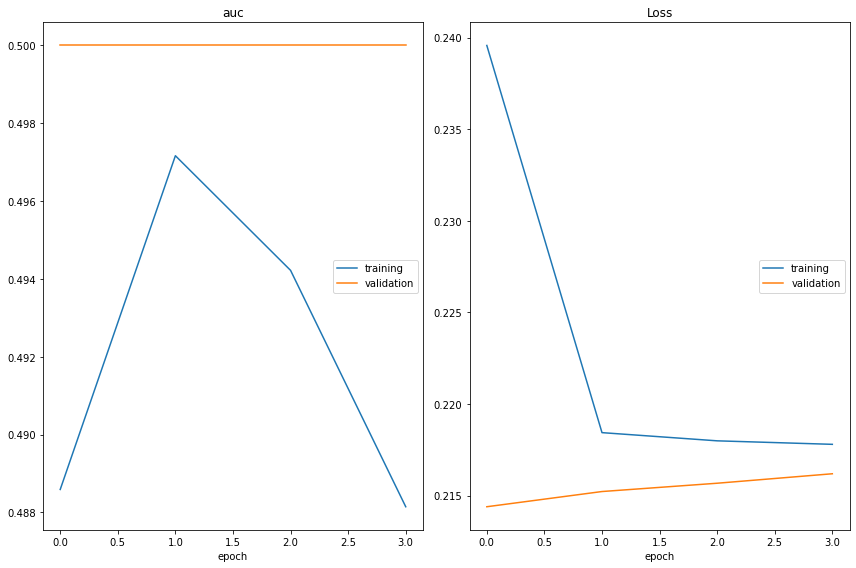

auc
	training         	 (min:    0.488, max:    0.497, cur:    0.488)
	validation       	 (min:    0.500, max:    0.500, cur:    0.500)
Loss
	training         	 (min:    0.218, max:    0.240, cur:    0.218)
	validation       	 (min:    0.214, max:    0.216, cur:    0.216)
141/141 [==============================] - 150s 1s/step - loss: 0.2178 - auc: 0.4881 - val_loss: 0.2162 - val_auc: 0.5000
Epoch 5/25
 81/141 [================>.............] - ETA: 39s - loss: 0.2143 - auc: 0.5001

KeyboardInterrupt: 

In [18]:
start = time.time()
history = model.fit(image_train, epochs=epoch, validation_data=image_val, callbacks=[checkpoint,PlotLossesKeras()],verbose=1)
end_train = time.time() - start

In [ ]:
model.save('model_{}'.format(model_name))

In [ ]:
import os
model.save_weights("{}_weights.h5".format(model_name))
file_stats = os.stat("{}_weights.h5".format(model_name))
model_size = round(file_stats.st_size / (1024 * 1024), 2)
model_parameter = model.count_params()

In [ ]:
import pickle

with open('trainHistoryDict', 'wb') as file_pi:
        pickle.dump(history.history, file_pi)

In [ ]:
#Load Model
from tensorflow import keras
model_fusion = keras.models.load_model('./model_{}/'.format(model_name))

In [ ]:
predicted_vals = model_fusion.predict_generator(image_val, steps = len(image_val))

In [ ]:
auc_rocs = util.get_roc_curve(labels, predicted_vals, image_val)

In [ ]:
from numba import cuda 
device = cuda.get_current_device()
device.reset()
print(device)

In [ ]:
# from sklearn.metrics import confusion_matrix
# from sklearn.metrics import classification_report
# from sklearn.metrics import precision_score
# from sklearn.metrics import recall_score
# from sklearn.metrics import multilabel_confusion_matrix
# from sklearn.metrics import f1_score
# from sklearn.metrics import accuracy_score

# start = time.time()
# y_prob = model_fusion.predict(image_val)
# end_test = time.time() - start

# y_pred = np.argmax(y_prob, axis=1)
# y_true = image_val.classes

# print("Precision:", precision_score(y_true, y_pred, average='weighted'), "Recall:", recall_score(y_true, y_pred, average='weighted'))

# cm = multilabel_confusion_matrix(y_true, y_pred)

# a = []

# for i in range(len(cm)):
#     a.append(cm[i].ravel())

# tp, fn, fp, tn =np.sum(np.array(a), axis = 0)

# print("tp, fn, fp, tn:", tp, fn, fp, tn)

# print("Specificity:", tn / (tn+fp), "Sensitivity:", tp / (tp+fn))
# print("F1-Score:", f1_score(y_true, y_pred, average='weighted'), "Accuracy:", accuracy_score(y_true, y_pred))

# Specificty = tn / (tn+fp)
# Sensitivity = tp / (tp+fn)
# F1_Score = f1_score(y_true, y_pred, average='weighted')
# Accuracy = accuracy_score(y_true, y_pred)

In [ ]:
# result = [y_true, y_pred]
# pd.DataFrame(result).to_csv("{}_{}_result.csv".format(model_name, n_fold))
# pd.DataFrame(y_prob).to_csv("{}_{}_probability.csv".format(model_name, n_fold))

In [ ]:
# from sklearn.metrics import roc_curve
# from sklearn.metrics import roc_auc_score

# fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_true, y_pred)
# m_auc = roc_auc_score(y_true, y_pred)

# print(fpr_keras, tpr_keras, thresholds_keras, m_auc)

# from sklearn.metrics import auc
# auc_keras = auc(fpr_keras, tpr_keras)
# print(auc_keras)

In [ ]:
# # keep probabilities for the positive outcome only
# lr_probs = y_prob[:, 1]
# lr_auc = roc_auc_score(y_true, lr_probs)
# print('Model Fusion: ROC AUC=%.3f' % (lr_auc))

# lr_fpr, lr_tpr, _ = roc_curve(y_true, lr_probs)

# plt.figure(figsize=(10, 10))
# font={'size':'15'}
# plt.rc('font',**font)

# plt.plot([0, 1], [0, 1], 'k--', label='No Skill')
# plt.plot(lr_fpr, lr_tpr, marker='.', label='{} Model ROC curve (area = %0.2f)'.format(model_name) % lr_auc)

# roc_auc = [lr_fpr, lr_fpr]
# pd.DataFrame(roc_auc).to_csv("{}_roc_auc.csv".format(model_name))

# # axis labels
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# # show the legend
# plt.legend()

# AUC_Score = lr_auc

In [ ]:
# Result = [Specificty, Sensitivity, F1_Score, Accuracy, AUC_Score, end_train, end_test, model_size, model_parameter]
# colname = ['Specificty', 'Sensitivity', 'F1_Score', 'Accuracy', 'AUC_Score', 'end_train', 'end_test', 'model_size', 'model_parameter']

# pd.DataFrame([Result], columns=colname).to_csv("{}_fold_".format(model_name)+str(n_fold)+".csv")

In [ ]:
# from sklearn.metrics import ConfusionMatrixDisplay
# from sklearn.metrics import confusion_matrix
# import matplotlib.pyplot as plt

# plt.figure(figsize=(15, 15))

# labels = ["Sperm", "Impurity"]
# cm = confusion_matrix(y_true, y_pred)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

# plt.rcParams['figure.figsize']=[15,15]
# font={'size':'30'}
# plt.rc('font',**font)
# disp.plot(cmap=plt.cm.Blues)